### Thank you for the opportunity to complete this data challenge. After exploring and organizing the data, I created a function to visualize GAD-7 scores over time for any patient, relative to the intervention threshold (i.e., a score of 10 or higher). I then created a set of pandas filters to produce a daily list of users who have just crossed the intervention threshold, sorted by order of descending symptom severity. (My thinking was that this sort of "near-real-time" snapshot would be critical to organization vested in providing the earliest possible interventions to their most at-risk folks.) I showed how this approach can be layered with the aforementioned visualization function to 1) get a list patients who are experiencing the most disruptive anxious disturbances and 2) quickly visualize their self-report history to check for trends before 3) intervening to provide the best, most informed care possible.

### A more complete visualization solution would benefit from additional data dimensions. I'd like to know, for instance, the results from some other clinical inventory (e.g., Beck's Depression Inventory, substance/alcohol use scales), or some physiological data (e.g., heart rate variability, sleep patterns, etc.). This could allow interventionists to identify the absolute most at-risk folks and direct care accordingly. From a scientific standpoint, it would go toward amassing a potentially dataset that could shine new light on the anxious phenotype.

### To do a bit of business-facing analysis, I projected NeuroFlow's year-over-year growth up to 2028 based on retention rates gleaned from time-series analysis of within-users GAD-7 submissions. Impressively, 65% of NeuroFlow's 2019 users continued to engage with the platform in 2020 (i.e., by submitting at least additional GAD-7 inventory). I then organizing GAD-7 submissions by month, and used those data as a proxy for NeuroFlow's monthly engagement over time. Engagement climbed steadily throughout 2019, peaked in early 2020, and had dipped slightly by mid-2020. I'm curious as to why some users are disengaged, and how their organizations might improve engagement. That said, an "org ID" tag would be helpful in the data table, because there may be "silver bullet" approaches that would allow client-facing folks like Elizabeth Cal to swoop into a disengaged organization and completely turn things around.

### An exploratory analysis revealed a non-significant trend toward higher self-reported anxiety among "power users" who've completed 15 or more GAD-7 self-assessments (Mann-WhitneyU nonparametric test; p=.069). Though non-significant, this finding hints toward the interesting possibility that NeuroFlow's is eliciting higher engagement from users who are at elevated risk.



In [786]:
# I created this ipynb in Python 3.8.3 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## First, we'll load the data and have a look at it to check for pitfalls like duplicates, NaN values, etc.

In [384]:
# load the .csv file as a pandas dataframe and look at its dimensions and first few rows:
df = pd.read_csv('/Users/Dan/Downloads/neuroflow_data_challenge/phq_all_final.csv')
print(df.shape)
df.head()

(53698, 5)


,date,patient_id,type,patient_date_created,score
0,2019-08-26T13:32:43.019162,8430,gad7,2019-06-03T13:23:02.63568,6
1,2019-11-15T17:55:11.364877,8430,gad7,2019-06-03T13:23:02.63568,1
2,2019-10-07T18:23:29.611351,14338,gad7,2019-06-03T13:32:30.66846,10
3,2019-11-04T20:16:28.610965,14338,gad7,2019-06-03T13:32:30.66846,7
4,2019-12-02T20:56:55.966354,14338,gad7,2019-06-03T13:32:30.66846,9


In [385]:
# check for duplicate rows:
True in df.duplicated().to_list()

False

In [386]:
# see what data types are in the dataframe:
df.dtypes

date                    object
patient_id               int64
type                    object
patient_date_created    object
score                    int64
dtype: object

In [401]:
# since dates are not in datetime format, convert those columns:
phq_df = df    
phq_df['date'] = pd.to_datetime(phq_df['date'])
phq_df['patient_date_created'] = pd.to_datetime(phq_df['patient_date_created'])
phq_df['patient_date_created']

0       2019-06-03 13:23:02.635680
1       2019-06-03 13:23:02.635680
2       2019-06-03 13:32:30.668460
3       2019-06-03 13:32:30.668460
4       2019-06-03 13:32:30.668460
                   ...            
53693   2020-07-31 13:54:20.164253
53694   2020-07-31 15:06:51.043730
53695   2020-07-31 15:40:07.726529
53696   2020-07-31 17:33:27.096572
53697   2020-07-31 17:58:21.004418
Name: patient_date_created, Length: 53698, dtype: datetime64[ns]

In [402]:
# check to see whether 'type' is always 'gad7':
phq_df['type'].nunique()

1

In [403]:
# count the total number of patients represented in the dataframe:
phq_df['patient_id'].nunique()

15502

In [404]:
# check for NaN values:
phq_df.isnull().any()

date                    False
patient_id              False
type                    False
patient_date_created    False
score                   False
dtype: bool

## Now that we're reasonably confident with the cleanliness and completeness of the data, we can shift gears to think of how we can use this to give a provider some insights

In [775]:
# find a super-user (i.e., the patient with the most assessments):
super_user = phq_df['patient_id'].mode()[0]
phq_df[phq_df['patient_id']==super_user].head()

,date,patient_id,type,patient_date_created,score
572,2019-06-18 13:18:43.179145,10687,gad7,2019-06-12 16:32:01.993418,13
573,2019-06-20 06:01:13.569266,10687,gad7,2019-06-12 16:32:01.993418,12
574,2019-06-22 13:32:11.049223,10687,gad7,2019-06-12 16:32:01.993418,14
575,2019-06-24 06:07:19.920380,10687,gad7,2019-06-12 16:32:01.993418,15
576,2019-06-26 05:54:12.661853,10687,gad7,2019-06-12 16:32:01.993418,9


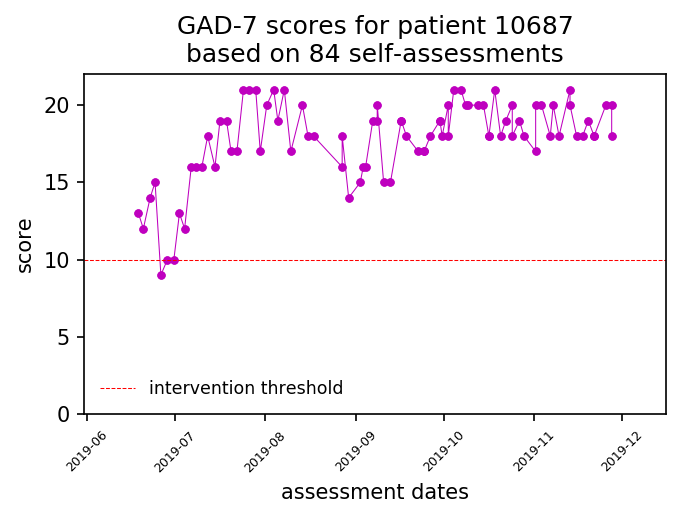

In [785]:
# Let's say I'm a provider and I want some easy way to visualize risk based on self-assessment over time.
# This function allows me to visualize any patient's account-creation date and changes to their gad7 score over time:

def gad7_viz(patient_id, df = phq_df):
    # truncate the main dataframe down to a patient-specific dataframe:
    patient_df = df[df['patient_id'] == patient_id]
    
    # plot the patient's score across time:
    x = patient_df['date']
    y = patient_df['score']
    plt.figure(figsize=(5, 3), dpi=150)
    plt.title(f'GAD-7 scores for patient {patient_id}\nbased on {len(y)} self-assessments')
    plt.scatter(x, y, marker='.', c='m')
    plt.plot(x, y, marker='.', c='m', lw=.5)
    plt.xlabel('assessment dates', size=10)
    plt.xticks(size=6, rotation=45)
    plt.ylim(0, 22) 
    plt.ylabel('score', size=10)
    plt.axhline(10, ls='--', color='r', lw=.5, label='intervention threshold')
    plt.legend(framealpha=0, fontsize='small')
    plt.show()
    
    return(None)

# visualize the plot for our super-user...
gad7_viz(super_user)

# ...or for a randomly-selected user:
# gad7_viz(np.random.choice(phq_df['patient_id']))

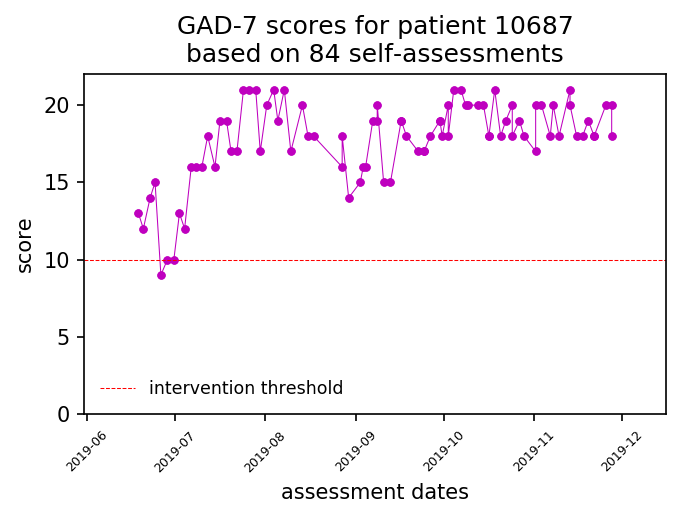

In [779]:
# Let's say I'm a provider and I want some easy way to visualize risk based on self-assessment over time.
# This function allows me to visualize any patient's account-creation date and changes to their gad7 score over time:

def gad7_viz(patient_id, df = phq_df):
    # truncate the main dataframe down to a patient-specific dataframe:
    patient_df = df[df['patient_id'] == patient_id]
    
    # plot the patient's score across time:
    x = patient_df['date']
    y = patient_df['score']
    plt.figure(figsize=(5, 3), dpi=150)
    plt.title(f'GAD-7 scores for patient {patient_id}\nbased on {len(y)} self-assessments')
    plt.scatter(x, y, marker='.', c='m')
    plt.plot(x, y, marker='.', c='m', lw=.5)
    plt.xlabel('assessment dates', size=10)
    plt.xticks(size=6, rotation=45)
    plt.ylim(0, 22) 
    plt.ylabel('score', size=10)
    plt.axhline(10, ls='--', color='r', lw=.5, label='intervention threshold')
    plt.legend(framealpha=0, fontsize='small')
    plt.show()
    
    return(None)

# visualize the plot for our super-user...
gad7_viz(super_user)

# ...or for a randomly-selected user:
# gad7_viz(np.random.choice(phq_df['patient_id']))

## Identifying users as they cross the clinical-intervention threshold is critical to safeguarding against the most adverse outcomes and getting folks on track toward healthy day-to-day functioning. If I was a provider, I'd want to know which of my patients are most at-risk, in near-real-time.

## We can do this with a daily pull:

In [783]:
# We can create a dataframe of at-risk users who've scored above 10 on the GAD-7 inventory
# and parse that dataframe so we see the most recent submissions with scores of 10+ first.
# e.g.:
intervention_df = phq_df[ phq_df['score'] >= 10].sort_values(by='date', ascending=False).reset_index(drop=True)

# From there, here's a way to see the most recent day's worth of GAD7-based intervention alerts, sorted by severity of self-reported anxiety:
todays_interventions = intervention_df[ intervention_df['date'].dt.strftime('%m-%d-%y') == intervention_df['date'].dt.strftime('%m-%d-%y')[0]]
todays_interventions.drop(['patient_date_created'], axis=1).sort_values(by='score', ascending=False)

,date,patient_id,type,score
7,2020-07-31 17:25:45.252182,14400,gad7,20
18,2020-07-31 02:53:42.335123,9037,gad7,19
5,2020-07-31 18:04:03.289169,9773,gad7,19
16,2020-07-31 13:37:06.991281,1774,gad7,19
6,2020-07-31 18:03:06.408063,9773,gad7,18
11,2020-07-31 16:16:20.140175,14336,gad7,18
3,2020-07-31 18:36:14.993781,16776,gad7,17
13,2020-07-31 15:14:39.479233,6458,gad7,17
15,2020-07-31 14:00:23.095356,11621,gad7,15
12,2020-07-31 15:27:37.128012,17348,gad7,15


## This approach can be layered with the individual-patient GAD-7 viz function to review patients' self-report history before reaching out, which could improve quality fo care. E.g., "*Has something happened this month that's made you feel more anxious?*"

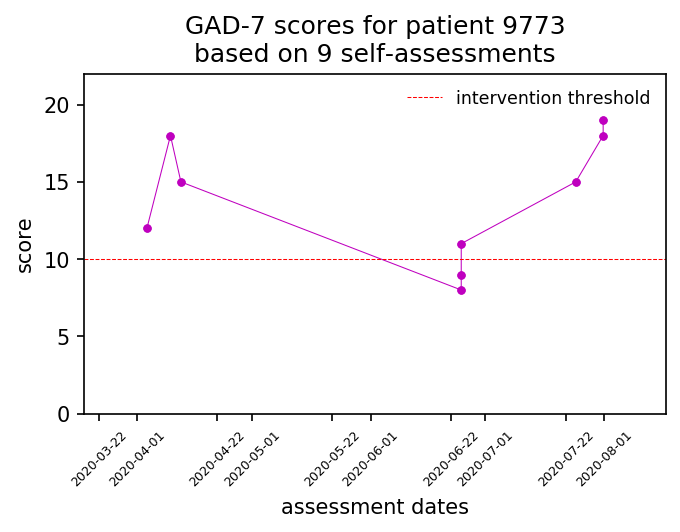

In [781]:
# E.g., looks like patient 9773 is feeling quite anxious today.
# Let's visualize their previous reports so we can offer the best possible care:
gad7_viz(9773)

## To shift gears a little, we have a cursory look at some business-facing analytics, like retention, and use that to project growth (with the caveat that a real growth projection would be much more complex than this, of course).

In [574]:
# We'll create some time-bound dataframes to look at time-series trends for business analytics:
df_2019 = phq_df[phq_df['date'].dt.year == 2019]
df_2020 = phq_df[phq_df['date'].dt.year == 2020]
print(len(df_2019), len(df_2020))

13457 40241


In [575]:
# create lists of unique users for each year:
all_2019_users = df_2019['patient_id'].unique()
all_2020_users = df_2020['patient_id'].unique()
print(len(all_2019_users), len(all_2020_users))

5260 13660


In [569]:
# use a set intersection to see how many users completed a GAD-7 assessment in both 2019 and 2020:
retained_users = set(all_2019_users).intersection(all_2020_users)
len(retained_users)

3418


In [646]:
# estimate a retention rate: 
retention_rate = len(retained_users)/len(all_2019_users)
np.round(retention_rate, 2)

0.65

In [682]:
# We can also investigate trends on a per-month basis; for example, to 
# see how many assessments were submitted per month during this period:

monthly_gad7 = phq_df['date'].groupby(phq_df.date.dt.to_period("M")).agg('count')
print(monthly_gad7)

date
2019-06     177
2019-07     471
2019-08    1067
2019-09    1950
2019-10    2744
2019-11    3234
2019-12    3814
2020-01    4953
2020-02    5304
2020-03    6158
2020-04    7072
2020-05    5797
2020-06    5420
2020-07    5537
Freq: M, Name: date, dtype: int64


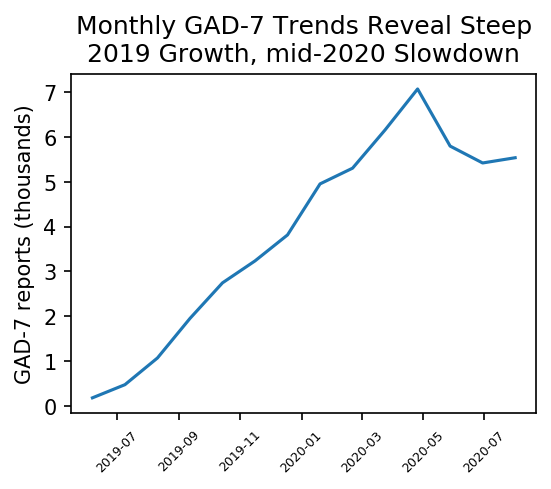

In [701]:
# If we treat GAD-7 self-reports (i.e., engagement) as a proxy for growth (just an assumption),
# the data reveal strong engagement/growth numbers throughout 2019, leading to a peak in
# mid-2020, followed by a slight dip:

my_dates = pd.date_range(start = np.min(phq_df['date']), end = np.max(phq_df['date']), periods=len(monthly_gad7))
plt.figure(figsize=(4, 3))
plt.plot(my_dates, [i/1000 for i in monthly_gad7])
plt.title('Monthly GAD-7 Trends Reveal Steep\n2019 Growth, mid-2020 Slowdown')
plt.xticks(rotation=45, size=6)
plt.ylabel("GAD-7 reports (thousands)")
plt.show()

In [593]:
# We'll use annual data to calculate a growth rate:
new_users = len(all_2020_users) - len(retained_users)
growth_rate = new_users/len(all_2019_users)
np.round(growth_rate, 2)

1.95

In [647]:
# This allows us to project 2020 -> 2012 retention:
int(len(all_2020_users)*retention_rate)

8876

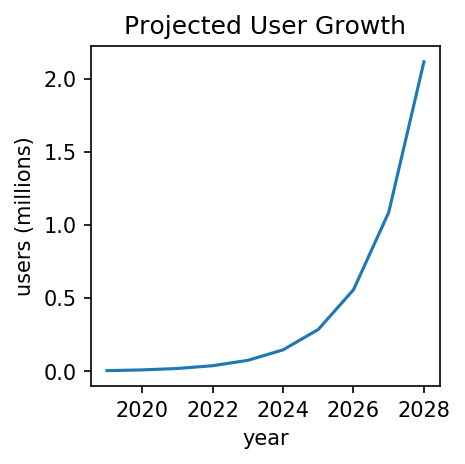

In [632]:
# We can visualize a longer growth projection assuming a stable growth trend at 2019-2020 growth rate.
# (lots of assumptions here, of course; also I imagine NeuroFlow's total users is different than its total number of GAD-7 respondents)
user_seed = len(all_2019_users)
projected_users = []
counter = len(all_2019_users)
year = np.arange(2019, 2029)
for i in range(len(year)):
    projected_users.append(int(user_seed))
    update_seed = (user_seed * growth_rate)
    user_seed = update_seed
projected_users
plt.figure(figsize=(3, 3))
plt.title('Projected User Growth')
plt.xlabel('year')
plt.ylabel('users (millions)')
plt.plot(year, [i/1000000 for i in projected_users])
plt.show()

## Shifting gears again, we can look at relationships between engagement and self-reported measures of anxiety.

## We might suspect, for instance, that NF is most engaging to its "power users" because those users are getting the biggest net benefit from the experience.

In [616]:
# Let's say I'm interested in learning whether there's a difference in GAD-7 self-reporting between NF's most ative and less-active users.
# To begin to answer this, we can filter our dataframe to create new dfs for two groups: 'power users', and less-active users.
power_users = phq_df.groupby('patient_id').filter(lambda x : len(x)>=15)
less_active_users = phq_df.groupby('patient_id').filter(lambda x : 2<=len(x)<=5)
print(len(power_users), len(less_active_users)) #checking the length of each group... as is normal, far more fringe users than super-users

1966 26630


In [617]:
less_active_users.tail()

,date,patient_id,type,patient_date_created,score
53572,2020-07-28 13:54:40.927615,8852,gad7,2020-07-23 19:46:10.296914,21
53608,2020-07-30 12:57:58.187604,1774,gad7,2020-07-27 19:54:28.003790,13
53609,2020-07-31 13:37:06.991281,1774,gad7,2020-07-27 19:54:28.003790,19
53650,2020-07-29 15:13:26.907738,2372,gad7,2020-07-28 22:44:02.812806,3
53651,2020-07-29 15:27:42.936980,2372,gad7,2020-07-28 22:44:02.812806,2


In [618]:
# Since we have a much larger group of less-active users, we can draw a random sample of 25 such users for visualization's sake:
random_draw = np.random.choice(less_active_users['patient_id'], 25, replace=False)

# We need to ensure that our random sample is still meaningfully grouped by patient_id, so that we get EVERY assessment from these 25
less_active_sample = less_active_users[less_active_users['patient_id'].isin(random_draw)]

In [619]:
less_active_sample.tail()

,date,patient_id,type,patient_date_created,score
49194,2020-05-13 23:58:09.249021,7306,gad7,2020-04-22 14:39:42.442841,3
49195,2020-06-26 21:56:06.725868,7306,gad7,2020-04-22 14:39:42.442841,5
51365,2020-05-28 15:01:52.023481,9330,gad7,2020-05-28 15:01:34.848607,7
51366,2020-06-29 16:14:43.270866,9330,gad7,2020-05-28 15:01:34.848607,0
51367,2020-07-30 14:34:21.739243,9330,gad7,2020-05-28 15:01:34.848607,3


In [673]:
# parse some info about our power users (e.g., how many assessments they've done, what their mean GAD-7 score is, when they created their accounts...)
account_creation_dates = []
num_assessments_taken  = []
mean_assessment_score  = []
for users in [power_users, less_active_users]:
    temp_account_creation_dates = []
    temp_num_assessments_taken  = []
    temp_mean_assessment_score  = []
    for i in users['patient_id'].unique():
        born_on = users['patient_date_created'][users['patient_id']==i]
        for dtg in born_on:
            temp_account_creation_dates.append(dtg)
            break
        pass
        temp_num_assessments_taken.append(users['patient_id'].value_counts()[i])
        temp_mean_assessment_score.append(np.mean(users.loc[users['patient_id'] == i, 'score']))
    account_creation_dates.append(temp_account_creation_dates)
    num_assessments_taken.append(temp_num_assessments_taken)
    mean_assessment_score.append(temp_mean_assessment_score)
        # (there's definitely a more 'pandonic' way to do this...)

In [676]:
# since the data are likely non-normal, we'll compare the groups with a nonparametric test:
from scipy.stats import mannwhitneyu
mwu = mannwhitneyu(mean_assessment_score[0], mean_assessment_score[1])
print(f'Mann-WhitneyU test did not return a significant result: p = {np.round(mwu[1], 3)}')

# no difference between average assessment scores for the power and less-active samples.
# although there's a trend emerging that could suggest NF's engagement is best with the 
# most at-risk users, it's not statistically significant (MWU p = .069).


Mann-WhitneyU test did not return a significant result: p = 0.069


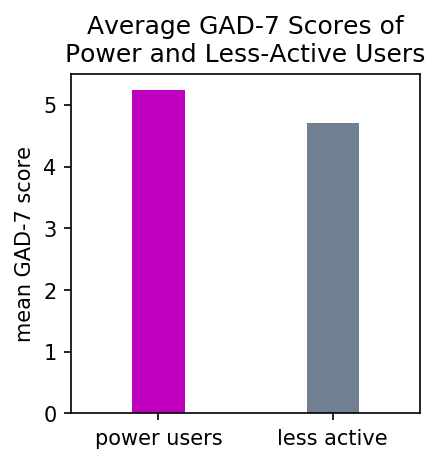

In [702]:
# We can visualize the difference, here:
plt.figure(figsize=(3, 3))
ax = plt.gca()
labels = ['power users', 'less active']
cols = ['m', 'slategrey']
w = .15
x_l = .25
x_r = .75
ax.bar(x_l, np.mean(mean_assessment_score[0]), width=w, color=cols[0], label=labels[0])
ax.bar(x_r, np.mean(mean_assessment_score[1]), width=w, color=cols[1], label=labels[1])
ax.set_xticks([x_l, x_r])
ax.set_xticklabels(labels)
ax.set_title('Average GAD-7 Scores of\nPower and Less-Active Users')
ax.set_xlim(0, 1)
ax.set_ylabel('mean GAD-7 score')
plt.show()

## Here on down is just some throwaway code (ran out of time)

In [ ]:
# Since we have a much larger group of less-active users, we can draw a random sample of 25 such users for visualization's sake:
random_draw = np.random.choice(less_active_users['patient_id'], 25, replace=False)

# We need to ensure that our random sample is still meaningfully grouped by patient_id, so that we get EVERY assessment from these 25
less_active_sample = less_active_users[less_active_users['patient_id'].isin(random_draw)]